In [1]:
### GPT config file

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "ctx_len": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

## GPT model Architecture

In [106]:
import torch.nn as nn
import torch

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]) ## Transformer Block
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False) ## Last layer convert embedding_size ==> vocab_size

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds 
        
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
    

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # dim=-1 find mean across each sentence means across columns
        var = x.var(dim=-1, keepdim=True, unbiased=False) ## unbiased = False because of Bessel's correction
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift 
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )

    def forward(self, x):
        return self.layers(x)
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, block_size, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"
        self.d_out = d_out 
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(block_size, block_size), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # print("keys: ", keys.shape)
        # print("queries: ", queries.shape)
        # print("values: ", values.shape)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # print("\n\nAdding num_head dimension ==>\n-------------------")
        # print("keys: ", keys.shape)
        # print("queries: ", queries.shape)
        # print("values: ", values.shape)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # print("\n\nTranspose all keys, queries, values ==>\n-------------------")
        # print("keys: ", keys.shape)
        # print("queries: ", queries.shape)
        # print("values: ", values.shape)

        attn_scores = queries @ keys.transpose(2, 3)

        # print("\n\nAttention_score after Q @ K(2,3) ==>\n-------------------")
        # print("Attention_score: ", attn_scores.shape)

        # print("Mask size:", self.mask.shape)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        mask_unsqueezed = mask_bool.unsqueeze(0).unsqueeze(0) # for extra matrix to fill attention score

        # print("Maintaining same shape as attn_score:", mask_unsqueezed.shape)
        attn_scores.masked_fill_(mask_unsqueezed, -torch.inf)

        # print("Masked attn_scores with mask_bool ==>")
        # Masked attention_score
        # print(attn_scores)

        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1) # make infinity ==> 0
        attn_weights = self.dropout(attn_weights)

        # print("\n\nAfter masking + softmax + dropout ==>\n-----------------")
        # print("attn_weights: ", attn_weights.shape)

        # again convert back to (batch_size, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 

        # print("Context vector: ", context_vec.shape)

        # contiguous: help to make memory accessing sequentially  because 
        # transpose() above make it non-contiguous
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # print("\n\nChange shape to (batch_size, num_tokens, d_out): ", context_vec.shape)
        context_vec = self.out_proj(context_vec)

        return context_vec 
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            block_size=cfg["ctx_len"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut 

        return x

In [99]:
## Testing multi-head attention 
import torch 

inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

batch = torch.stack((inputs, inputs), dim=0)
# print(batch)

torch.manual_seed(123)
batch_size, block_size, d_in = batch.size()
print(batch.shape)
d_out = 2
mha = MultiHeadAttention(d_in, d_out, block_size, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)

torch.Size([2, 6, 3])
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)


In [100]:
## Initializing Testing examples
import tiktoken
import torch 

tokenizer = tiktoken.get_encoding("gpt2")
batch = []

text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
print("Tensor before stacking\n", batch)

batch = torch.stack(batch, dim=0) ## I tried testing dim=0

print("Tensor after stacking\n", batch)


Tensor before stacking
 [tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
Tensor after stacking
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [101]:
## Testing LayerNorm
batch_example = torch.randn(2,6)
ln = LayerNorm(emb_dim=6)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[ 0.0000e+00],
        [-3.9736e-08]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


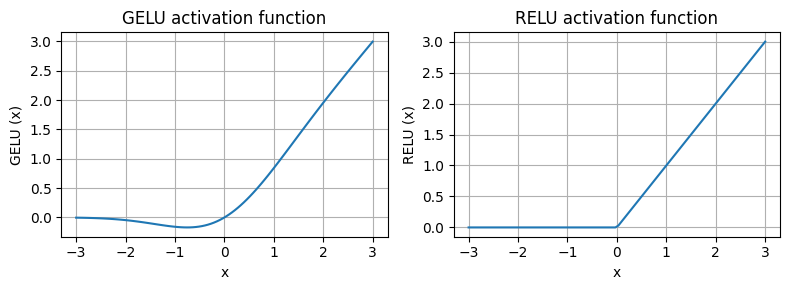

In [102]:
## testing GELU module
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100) # how to reach -3 to 3 in 100 steps
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
## Testing FeedForward Layer
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [104]:
## Testing Transformer Block
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [108]:
## Testing GPTModel function
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
print(batch.shape)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)


torch.Size([2, 4])
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.3836,  0.1907, -0.2999,  ...,  0.0701, -0.3504, -0.8911],
         [ 0.3457, -0.4659, -0.7705,  ..., -0.3331,  0.0161,  0.1663],
         [ 0.9492, -0.1808, -0.0225,  ...,  0.2096, -0.3042, -0.1051],
         [-0.8163,  0.3850, -0.2297,  ...,  1.0137,  0.4000, -0.4916]],

        [[ 0.0851,  0.1240, -0.0751,  ...,  0.5713,  0.2818, -0.6030],
         [ 0.0400, -0.2573,  0.0609,  ...,  0.5641, -0.1687,  0.3409],
         [ 0.9161,  1.0140, -0.2341,  ...,  0.2165,  0.5243,  0.1291],
         [ 0.1589,  0.2120,  0.6350,  ...,  0.9529, -0.1897, -0.3581]]],
       grad_fn=<UnsafeViewBackward0>)
